In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx
import re
import geopandas as gpd

%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.style.use('ggplot')

# The Data

In [2]:
url = 'https://raw.githubusercontent.com/dtrihinas/covid-19-cyprus-data/master/coronavirus_cyprus_data.csv'
data = pd.read_csv(url, index_col='caseid')
data['date'] = pd.to_datetime(data['date'], dayfirst=True).dt.date
print('Dataset includes', len(data.index), 'cases from', data['date'].min(), 'to', data['date'].max())
print('First 5 rows')
data.head()

Dataset includes 320 cases from 2020-03-10 to 2020-04-01
First 5 rows


,date,gender,age,nationality,area,impact,profession,hospitalized,ICU,recovered,relation,notes
caseid,,,,,,,,,,,,
1,2020-03-10,M,25.0,cypriot,limassol,travel (italy),NaN,0,0,1,-1,NaN
2,2020-03-10,M,64.0,cypriot,nicosia,travel (uk),doctor,0,0,1,-1,NaN
3,2020-03-11,M,NaN,cypriot,nicosia,travel (uk),pensioner,1,0,1,-1,NaN
4,2020-03-11,F,NaN,cypriot,nicosia,travel (uk),NaN,1,0,1,-1,NaN
5,2020-03-11,F,NaN,greek,limassol,travel (italy),NaN,1,0,1,-1,NaN


# Daily Cases

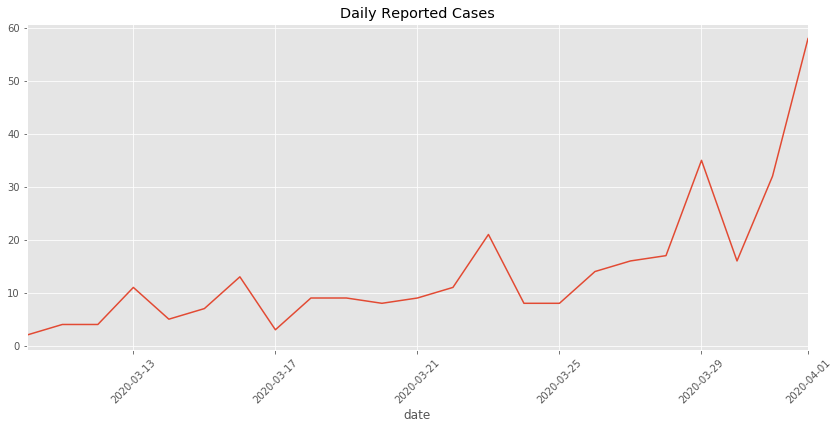

In [3]:
cum_cases = data.groupby('date').size()
cum_cases.plot(figsize=(14,6), title='Daily Reported Cases', rot=45)

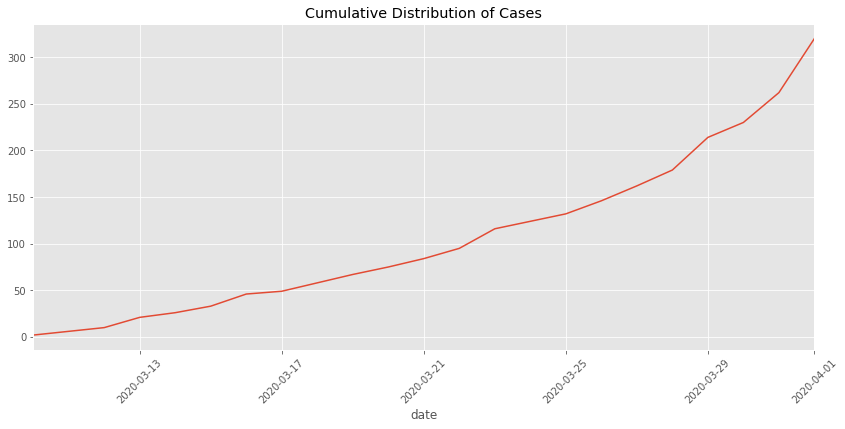

In [4]:
#Contributed by Elias Tziakouris
seriesCases = data.iloc[:, 0:1]
grpDate = data.groupby("date").size()
cumsum = grpDate.cumsum()
cumsum.plot(figsize=(14,6), title='Cumulative Distribution of Cases', rot=45)

# Case Impact Type

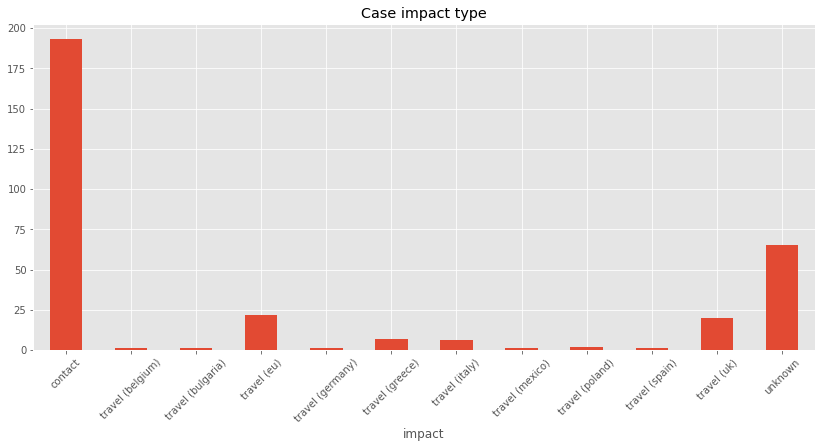

In [5]:
case_impact = data.groupby('impact').size()
case_impact.plot(kind='bar',x='impact',y='cases', title='Case impact type', rot=45, figsize=(14,6))

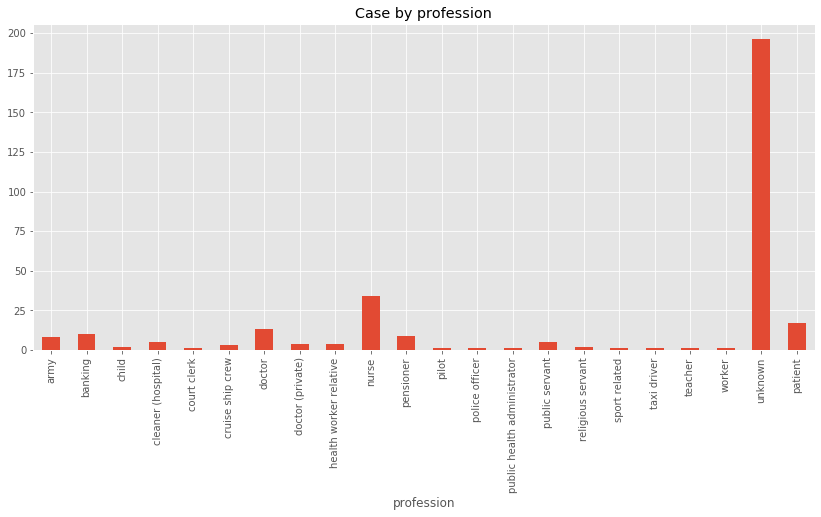

In [6]:
case_profession = data.groupby('profession').size()
unknown_prof = data.index.size - case_profession.sum()
case_profession['unknown'] = unknown_prof
patients = ~case_profession.index.str.extract(r'(^patient)').isna()[0].values #bool array matching patients
total_patient_count = case_profession[patients].sum() #merge patient count from different hospitals
case_profession[patients == True] = np.nan
case_profession = case_profession.dropna()
case_profession['patient'] = total_patient_count
case_profession.plot(kind='bar',x='profession',y='cases', title='Case by profession', rot=90, figsize=(14,6))

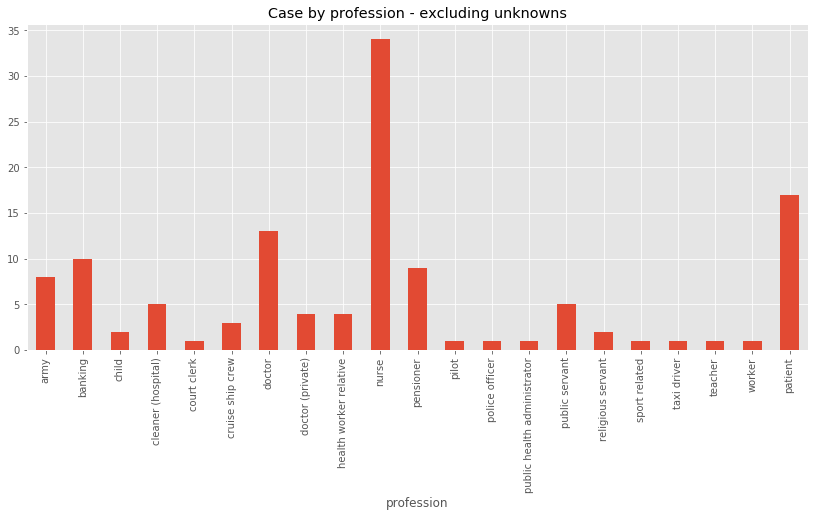

In [7]:
#Nice to see the above without unknown
case_profession = case_profession.drop(labels='unknown') if 'unknown' in case_profession else case_profession
case_profession.plot(kind='bar',x='profession',y='cases', title='Case by profession - excluding unknowns', rot=90, figsize=(14,6))

# Case Geomapping

In [8]:
cyprus_geojson_url = "https://raw.githubusercontent.com/dtrihinas/cyprus-geojson/master/cyprus.geojson"
geodata = gpd.read_file(cyprus_geojson_url)
geodata['population'] = geodata['population'].apply(lambda x : np.nan if x == 'NA' else float(x))
geodata['district'] = geodata['district'].str.lower()
geodata = geodata.set_index('district')

geodata['covid19_cases'] = data.groupby('area').size()
geodata['covid19_cases'] = geodata['covid19_cases'].apply(lambda x : 0 if np.isnan(x) else x)
geodata

,population,area,geometry,covid19_cases
district,,,,
limassol,239842.0,1393.3,"POLYGON ((33.26712 34.73809, 33.27604 34.71791...",11.0
paphos,90295.0,1389.8,"POLYGON ((32.74372 34.93407, 32.67162 34.96390...",51.0
larnaca,145365.0,1120.1,"POLYGON ((33.12481 34.88480, 33.12653 34.85213...",24.0
nicosia,334120.0,2710.0,"POLYGON ((32.93495 35.26356, 32.89444 35.17212...",32.0
kerynia,NaN,643.89999999999998,"POLYGON ((33.54710 35.28318, 33.60168 35.31541...",0.0
famagusta,47338.0,1985.3,"POLYGON ((33.64700 35.35770, 33.64426 35.32521...",13.0
british overseas territory (akrotiri),NaN,NA,"POLYGON ((32.75574 34.65129, 32.83951 34.66710...",0.0
british overseas territory (dhekelia),NaN,NA,"POLYGON ((33.70605 34.97600, 33.74176 34.97825...",0.0


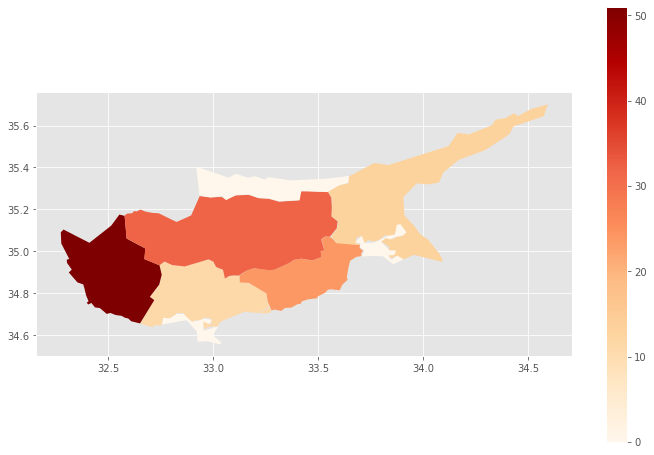

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
geodata.plot(column="covid19_cases", ax=ax, legend=True, cmap='OrRd')

# Community Detection (TODO)

In [10]:
g = nx.DiGraph()
g.add_nodes_from(data.index.values)

r1 = re.compile(r'travel')
r2 = re.compile(r'\((.*?)\)')
impact_filter = np.vectorize(lambda x : bool(r1.search(x)))
country_selector = np.vectorize(lambda x : r2.search(x).group(1))
d = data['impact'].unique()
country_arr = country_selector(d[impact_filter(d)])
g.add_nodes_from(country_arr)
print(g.nodes)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 2

In [11]:
def upd_edge_list(lst, tup):
    if isinstance(tup[1], float):
        pass #unknown contact connection
    elif tup[1] == '-1':
        if 'travel' in tup[2]:
            country = r2.search(tup[2]).group(1) 
            tup = (int(tup[0]), country) #travel cases link to country
        else:
            tup = (int(tup[0]), int(tup[0])) #unknown cases link to themselves
        lst.append(tup)
    elif '{' in tup[1]:
        x = re.findall(r'[0-9]+', tup[1]) 
        for i in x:
            lst.append((int(tup[0]), int(i))) #link to multiple cases
    else:
        lst.append((int(tup[0]),int(tup[1])))

elist = []

data.apply(lambda row : 
           upd_edge_list(elist, (row.name, row.relation, row.impact)), 
           axis=1)

elist

caseid
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
30     None
       ... 
291    None
292    None
293    None
294    None
295    None
296    None
297    None
298    None
299    None
300    None
301    None
302    None
303    None
304    None
305    None
306    None
307    None
308    None
309    None
310    None
311    None
312    None
313    None
314    None
315    None
316    None
317    None
318    None
319    None
320    None
Length: 320, dtype: object

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


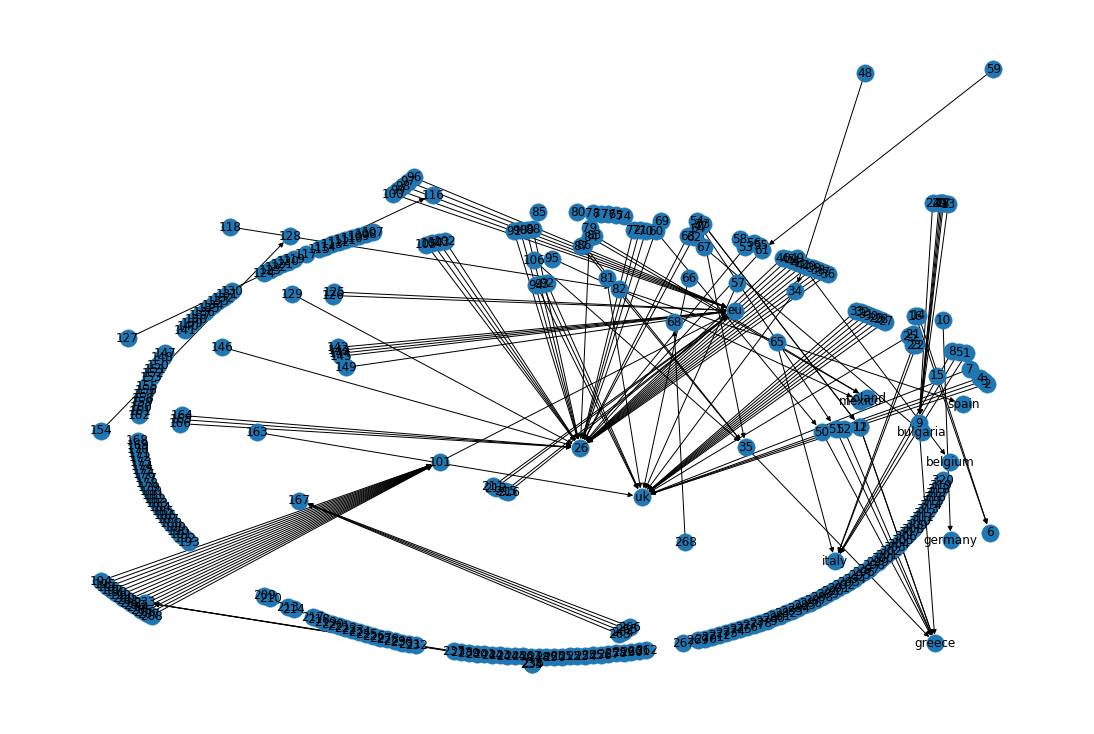

In [12]:
plt.figure(figsize=(15,10))
g.add_edges_from(elist)
nx.draw(g, with_labels = True, pos = nx.kamada_kawai_layout(g))